## **Check GPU**

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 Ti (UUID: GPU-981912e7-585f-49c2-1ad9-600372b88670)


In [2]:
# Check TensorFlow version (should be minimum 2.4.0+ but 2.13.0+ is better)
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

TensorFlow version: 2.14.0-dev20230620
Notebook last run (end-to-end): 2023-07-16 15:19:52.829310


## **Get helper functions**

In [3]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")


[INFO] 'helper_functions.py' already exists, skipping download.


## **Download Kaggle dataset**

In [7]:
import opendatasets as od
import pandas as pd

In [8]:
# Download data from Kaggle
od.download("https://www.kaggle.com/datasets/saloni1712/chatgpt-app-reviews")

Skipping, found downloaded files in ".\chatgpt-app-reviews" (use force=True to force download)


In [9]:
data = pd.read_csv('C:/Users/Nima/Desktop/ChatGPT_Reviews/chatgpt-app-reviews/chatgpt_reviews.csv')

In [10]:
data.shape

(2058, 4)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2058 entries, 0 to 2057
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    2058 non-null   object
 1   title   2058 non-null   object
 2   review  2058 non-null   object
 3   rating  2058 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 64.4+ KB


In [12]:
data.describe()

,rating
count,2058.000000
mean,3.744898
std,1.577841
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


In [13]:
data.describe(include='object')

,date,title,review
count,2058,2058,2058
unique,2053,1850,2033
top,2023-05-18 23:04:43,Finally,First
freq,2,13,5


## **Analysis of Rating column**

In [14]:
#Rating Distribution
data['rating'].value_counts().sort_index()

1     391
2     115
3     199
4     276
5    1077
Name: rating, dtype: int64

In [15]:
data['rating'].value_counts(normalize=True).mul(100).round(2).sort_index()

1    19.00
2     5.59
3     9.67
4    13.41
5    52.33
Name: rating, dtype: float64

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

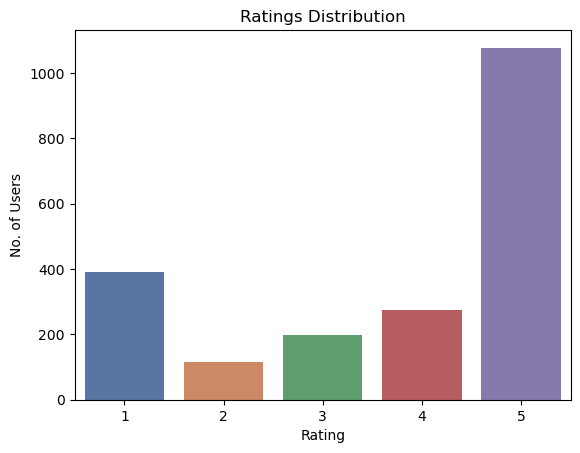

In [17]:
#Plot
palette = "deep"
sns.set_palette(palette)

sns.countplot(data=data, x='rating')

plt.xlabel('Rating')
plt.ylabel('No. of Users')
plt.title('Ratings Distribution')

plt.show()

## **Data Preprocessing**

In [18]:
#Find no. of missing values in each column
data.isnull().sum().sort_values(ascending=False)

date      0
title     0
review    0
rating    0
dtype: int64

In [19]:
#Combine Review Time and Review
data['complete_review'] = data['title'] +' .'+data['review']

In [20]:
#Drop some columns which we won't use for sentiment analysis of review
remove_cols = ['date','review','title']
data = data.drop(remove_cols,axis='columns')

In [21]:
data.head()

,rating,complete_review
0,4,Much more accessible for blind users than the ...
1,4,"4.5 stars, here’s why .I recently downloaded t..."
2,4,"Almost 5 stars, but… no search function .This ..."
3,4,"Good, but Siri support would take it to the ne..."
4,1,"App review .No doubt, this technology is absol..."


## **Convert all the reviews to lowercase**

In [22]:
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['complete_review'].head()

0    much more accessible for blind users than the ...
1    4.5 stars, here’s why .i recently downloaded t...
2    almost 5 stars, but… no search function .this ...
3    good, but siri support would take it to the ne...
4    app review .no doubt, this technology is absol...
Name: complete_review, dtype: object

## **Remove Punctuation**

In [23]:
data['complete_review'] = data['complete_review'].str.replace('[^\w\s]','')

C:\Users\Nima\AppData\Local\Temp\ipykernel_5704\3606737599.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data['complete_review'] = data['complete_review'].str.replace('[^\w\s]','')


## **Remove Emojis**

In [24]:
import re

In [25]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
data['complete_review'] = data['complete_review'].apply(lambda x: remove_emoji(x))

## **Remove Stopwords**

In [26]:
# Instal spaCy: https://spacy.io/usage
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_sm

                                              0.0/2.1 MB ? eta -:--:--
     -                                        0.1/2.1 MB 1.3 MB/s eta 0:00:02
     ---                                      0.2/2.1 MB 1.7 MB/s eta 0:00:02
     ----                                     0.3/2.1 MB 1.7 MB/s eta 0:00:02
     -------                                  0.4/2.1 MB 1.9 MB/s eta 0:00:01
     --------                                 0.4/2.1 MB 1.9 MB/s eta 0:00:01
     ----------                               0.6/2.1 MB 1.9 MB/s eta 0:00:01
     ------------                             0.7/2.1 MB 2.0 MB/s eta 0:00:01
     --------------                           0.8/2.1 MB 2.0 MB/s eta 0:00:01
     ----------------                         0.9/2.1 MB 2.1 MB/s eta 0:00:01
     ------------------                       1.0/2.1 MB 2.1 MB/s eta 0:00:01
     ---------------------                    1.1/2.1 MB 2.2 MB/s eta 0:00:01
     -----------------------                  1.2/2.1 MB 2.2 MB/s eta 0

ERROR: To modify pip, please run the following command:
C:\Users\Nima\anaconda3\envs\tensorflow_python_3_10\python.exe -m pip install -U pip setuptools wheel


                                              0.0/12.8 MB ? eta -:--:--
                                              0.1/12.8 MB 2.6 MB/s eta 0:00:05
     -                                        0.4/12.8 MB 6.3 MB/s eta 0:00:02
     --                                       0.7/12.8 MB 6.6 MB/s eta 0:00:02
     ---                                      1.1/12.8 MB 7.0 MB/s eta 0:00:02
     ----                                     1.4/12.8 MB 6.9 MB/s eta 0:00:02
     -----                                    1.8/12.8 MB 7.0 MB/s eta 0:00:02
     ------                                   2.0/12.8 MB 6.9 MB/s eta 0:00:02
     -------                                  2.5/12.8 MB 7.1 MB/s eta 0:00:02
     --------                                 2.8/12.8 MB 7.2 MB/s eta 0:00:02
     ---------                                3.2/12.8 MB 7.2 MB/s eta 0:00:02
     ----------                               3.4/12.8 MB 7.0 MB/s eta 0:00:02
     -----------                              3.8/12.8 MB 7

In [27]:
import nltk
from nltk.corpus import stopwords
import spacy

In [28]:
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nima\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [29]:
# nlp = spacy.load('en_core_web_sm')

In [30]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [31]:
stop = stopwords.words('english')
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

## **Apply Lemmatization**

In [32]:
def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])
data['complete_review']= data['complete_review'].apply(space)

## **Remove certain words**

In [33]:
words_to_remove = ['chatgpt','app','chatgpts','chat','gpt','iphone','ipad','gpt4','phone','number','ai','use','io']
data['complete_review'] = data['complete_review'].apply(lambda x: " ".join(x for x in x.split() if x not in words_to_remove))

## **Map ratings to positive, negative & neutral sentiment**

0 will represent negative sentiment

1 will represent neutral sentiment

2 will represent positive sentiment

In [34]:
data['sentiment'] = data['rating'].apply(lambda rating: 2 if rating > 3 else (1 if rating == 3 else 0))
data.head(5)

,rating,complete_review,sentiment
0,4,much accessible blind user web version point I...,2
1,4,45 star here recently download overall great p...,2
2,4,almost 5 star search function would almost per...,2
3,4,good siri support would take next level apprec...,2
4,1,review doubt technology absolutely lifechange ...,0


In [35]:
data['sentiment'].value_counts(normalize=True).mul(100).round(2)

2    65.74
0    24.59
1     9.67
Name: sentiment, dtype: float64

## **Reviews Analysis**

In [38]:
!pip install wordcloud

                                              0.0/152.1 kB ? eta -:--:--
     -------------------------------------- 152.1/152.1 kB 4.6 MB/s eta 0:00:00


In [39]:
from wordcloud import WordCloud, STOPWORDS

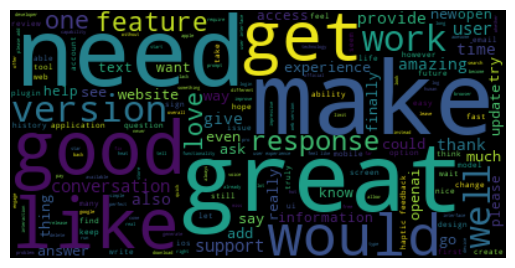

In [41]:
#Analysis of Review field
stopword = set(stopwords.words('english'))
text = " ".join(review for review in data.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [42]:
#positive negative & neutral sentiment:
positive = data[data['sentiment'] == 2]
negative = data[data['sentiment'] == 0]
neutral = data[data['sentiment'] == 1]

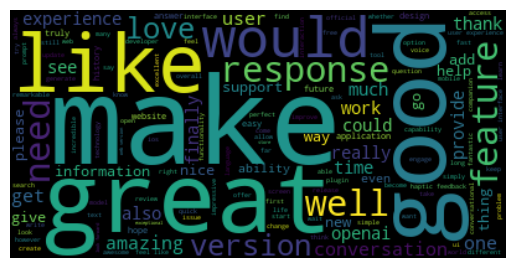

In [43]:
#Positive Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in positive.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

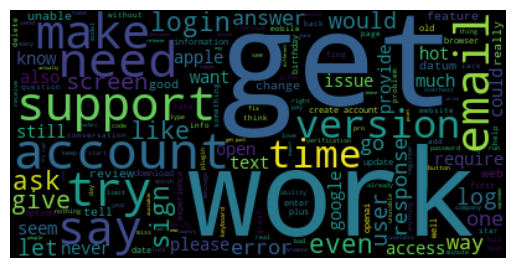

In [44]:
#Negative Setiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in negative.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

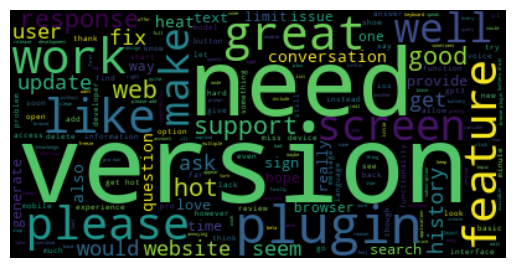

In [45]:
#Neutral Sentiment
stopword = set(stopwords.words('english'))
text = " ".join(review for review in neutral.complete_review)
wordcloud = WordCloud(stopwords=stopword).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## **Visualizing a text dataset**

## **Handle Imbalanced Data**

In [46]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split